# 普通統計數據可視化圖表 for ALL questions’ results, including 受訪者人口調查part.

## Q1. 你多大程度同意「回收 對環保及可持續發展很重要」？ To what extent do you agree that "recycling is important for environmental protection and sustainable development?"

In [1]:
pip install pandas matplotlib openpyxl


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


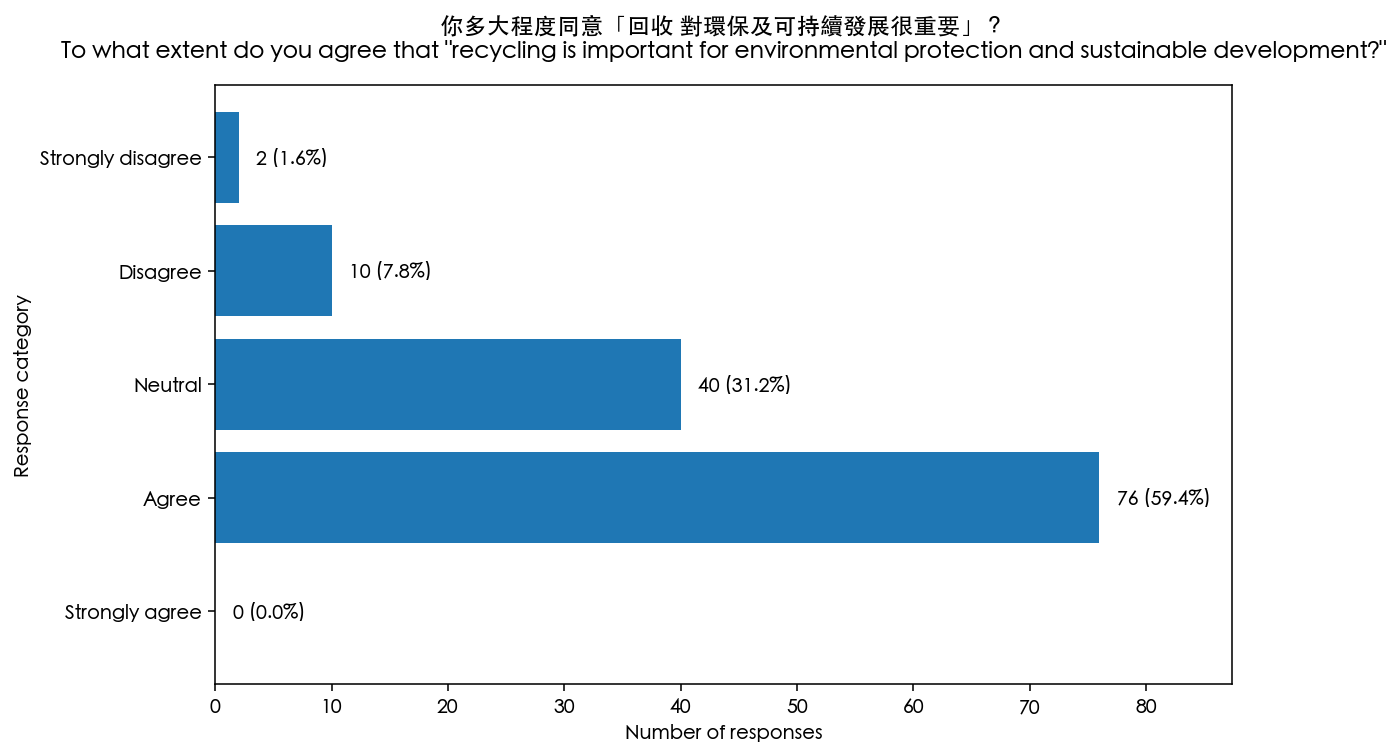

In [2]:
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager

# ---- 路徑 ----
EXCEL_PATH = Path("../GCAP3226 G@C Survey Responses_cleaned data.xlsx")

# ---- 欄位關鍵字（中英）----
QUESTION_CANDIDATES = [
    "你多大程度同意「回收 對環保及可持續發展很重要」",
    "回收 對環保及可持續發展很重要",
    "To what extent do you agree",
    "recycling is important for environmental protection and sustainable development",
]

# ---- Likert 順序與對應 ----
LIKERT_ORDER = ["Strongly disagree","Disagree","Neutral","Agree","Strongly agree"]
VALUE_MAP = {
    "strongly disagree":"Strongly disagree","disagree":"Disagree","neutral":"Neutral",
    "neither agree nor disagree":"Neutral","agree":"Agree","strongly agree":"Strongly agree",
    "1":"Strongly disagree","2":"Disagree","3":"Neutral","4":"Agree","5":"Strongly agree",
    "非常不同意":"Strongly disagree","不同意":"Disagree","中立":"Neutral","同意":"Agree","非常同意":"Strongly agree",
    "強烈不同意":"Strongly disagree","強烈同意":"Strongly agree",
}

# ---- 字型（盡量支援中文）----
preferred = ["Noto Sans CJK TC","Noto Sans CJK SC","Noto Sans CJK JP","Noto Sans TC","Noto Sans SC",
             "Microsoft JhengHei","PingFang TC","PingFang SC","Heiti TC","Heiti SC","Arial Unicode MS","SimHei"]
available = {f.name for f in font_manager.fontManager.ttflist}
for name in preferred:
    if name in available:
        plt.rcParams["font.family"] = name
        break

# ---- 載入資料 ----
df = pd.read_excel(EXCEL_PATH, sheet_name=0, engine="openpyxl")

# 找到目標題目欄
def _strip_punct(s): 
    return re.sub(r'[\s"\'“”‘’、，。！？!?,:：;；\-\(\)\[\]（）【】/]+', "", s.lower())

col = None
for c in df.columns:
    cl = str(c).lower()
    if any(k.lower() in cl for k in QUESTION_CANDIDATES):
        col = c; break
if col is None:
    cand = [_strip_punct(k) for k in QUESTION_CANDIDATES]
    for c in df.columns:
        if any(k in _strip_punct(str(c)) for k in cand):
            col = c; break
if col is None:
    raise KeyError("找不到該題欄位，請確認問句標題。")

# ---- 統計分佈 ----
def _norm(x):
    if pd.isna(x): return None
    s = str(x).strip(); low = re.sub(r"\s+"," ",s).lower()
    if low in VALUE_MAP: return VALUE_MAP[low]
    for k,v in VALUE_MAP.items():
        if k and k in low: return v
    return None

mapped = [m for m in (_norm(v) for v in df[col]) if m is not None]
counts = pd.Series(mapped).value_counts()
ordered = pd.Series([counts.get(k,0) for k in LIKERT_ORDER], index=LIKERT_ORDER)
# 可能有其他無法對應值
if len(mapped) != counts.sum():
    other = len(df[col]) - len([v for v in df[col] if pd.isna(v)]) - len(mapped)
    if other > 0:
        ordered["Other/Invalid"] = other

# ---- 繪圖（僅顯示）----
total = int(ordered.sum())
summary = ordered.reset_index()
summary.columns = ["Response","Count"]

fig, ax = plt.subplots(figsize=(9,5.5), dpi=140)
bars = ax.barh(summary["Response"], summary["Count"])

# 右側預留空間，避免文字超出圖框
max_count = max(summary["Count"].max(), 1)
ax.set_xlim(0, max_count * 1.15)   # 15% 右邊緩衝
# 也可用 ax.margins(x=0.12) 取得類似效果

# 標注數字與百分比（放在長條右側、但仍位於座標範圍內）
pct = (summary["Count"]/total*100).round(1)
for i, (cnt, p) in enumerate(zip(summary["Count"], pct)):
    ax.text(cnt + max(0.02*max_count, 0.5), i, f"{cnt} ({p}%)", va="center", ha="left")

ax.set_title(
    '你多大程度同意「回收 對環保及可持續發展很重要」？\n'
    'To what extent do you agree that "recycling is important for environmental protection and sustainable development?"',
    pad=14
)
ax.set_xlabel("Number of responses")
ax.set_ylabel("Response category")
ax.invert_yaxis()
plt.tight_layout()
plt.show()


## Q2. 你認爲自己對本地回收的了解程度屬於哪一水平？ How would you rate your level of knowledge about recycling?

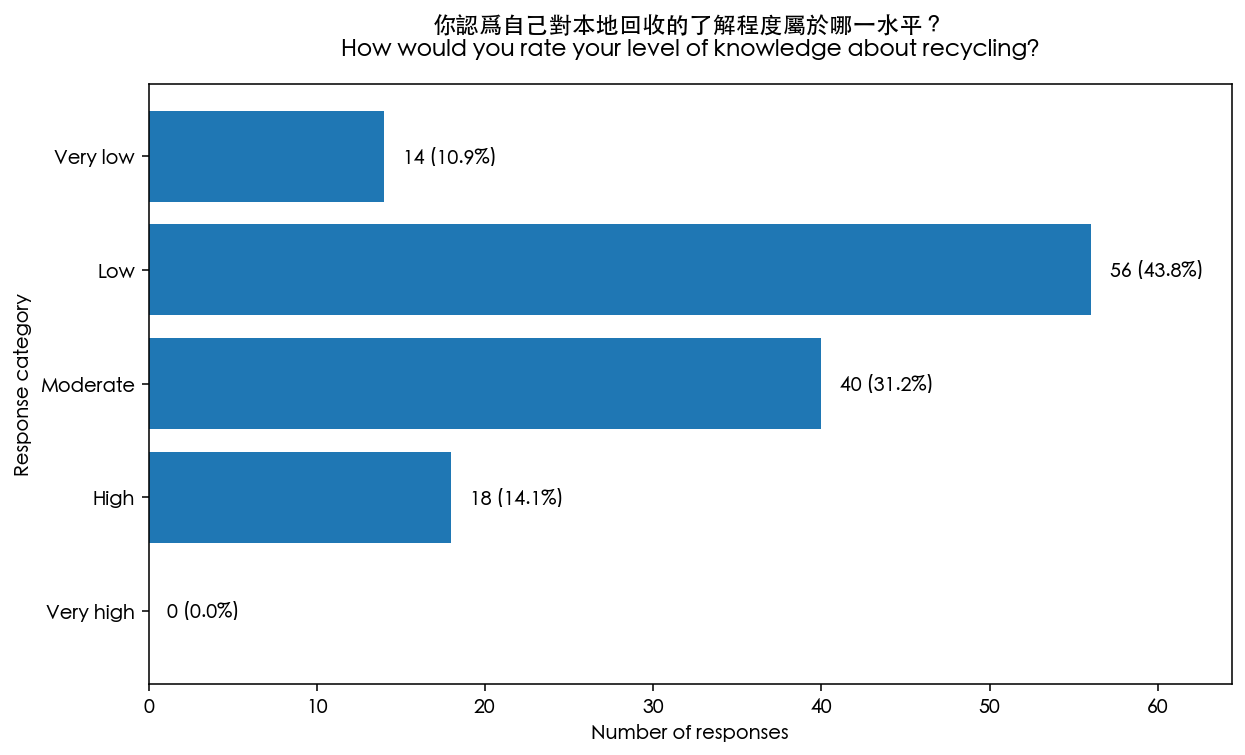

In [3]:
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager

# -----------------------------
# Configuration
# -----------------------------
EXCEL_PATH = Path("../GCAP3226 G@C Survey Responses_cleaned data.xlsx")

QUESTION_CANDIDATES = [
    "你認爲自己對本地回收的了解程度屬於哪一水平",
    "對本地回收的了解程度",
    "How would you rate your level of knowledge about recycling",
    "level of knowledge about recycling",
]

# Ascending knowledge order
LIKERT_ORDER = ["Very low", "Low", "Moderate", "High", "Very high"]

# Map common variants to normalized labels
VALUE_MAP = {
    # English
    "very low": "Very low", "low": "Low", "moderate": "Moderate",
    "medium": "Moderate", "average": "Moderate", "high": "High",
    "very high": "Very high", "excellent": "Very high",
    # Numeric encodings (1–5)
    "1": "Very low", "2": "Low", "3": "Moderate", "4": "High", "5": "Very high",
    # Chinese (common variants)
    "非常不了解": "Very low", "很不了解": "Very low", "不了解": "Low", "低": "Low",
    "一般": "Moderate", "中等": "Moderate", "普通": "Moderate",
    "了解": "High", "高": "High",
    "非常了解": "Very high", "很了解": "Very high", "極度了解": "Very high",
}

# -----------------------------
# Helpers
# -----------------------------
def set_cjk_font_if_available():
    preferred = [
        "Noto Sans CJK TC","Noto Sans CJK SC","Noto Sans CJK JP",
        "Noto Sans TC","Noto Sans SC","Microsoft JhengHei",
        "PingFang TC","PingFang SC","Heiti TC","Heiti SC",
        "Arial Unicode MS","SimHei",
    ]
    available = {f.name for f in font_manager.fontManager.ttflist}
    for name in preferred:
        if name in available:
            plt.rcParams["font.family"] = name
            break

def _strip_punct_lower(s: str) -> str:
    return re.sub(r'[\s"\'“”‘’、，。！？!?,:：;；\-\(\)\[\]（）【】/]+', "", s.lower())

def find_question_column(df: pd.DataFrame) -> str:
    # direct contains
    for col in df.columns:
        cl = str(col).lower()
        if any(k.lower() in cl for k in QUESTION_CANDIDATES):
            return col
    # fuzzy contains (punct/space stripped)
    candidates = [_strip_punct_lower(k) for k in QUESTION_CANDIDATES]
    for col in df.columns:
        if any(k in _strip_punct_lower(str(col)) for k in candidates):
            return col
    raise KeyError("Column for the recycling knowledge question was not found.")

def normalize_response(v):
    if pd.isna(v):
        return None
    s = str(v).strip()
    low = re.sub(r"\s+", " ", s).strip().lower()
    if low in VALUE_MAP:
        return VALUE_MAP[low]
    # substring fallback (handles labels with extra text)
    for k, val in VALUE_MAP.items():
        if k and k in low:
            return val
    return None

# -----------------------------
# Main (no prints, no saving)
# -----------------------------
set_cjk_font_if_available()

df = pd.read_excel(EXCEL_PATH, sheet_name=0, engine="openpyxl")
question_col = find_question_column(df)

mapped = [m for m in (normalize_response(x) for x in df[question_col]) if m is not None]
counts = pd.Series(mapped).value_counts()

ordered = pd.Series([counts.get(cat, 0) for cat in LIKERT_ORDER], index=LIKERT_ORDER)
# If there are unmapped non-null values, add an "Other/Invalid" bar
other = len([x for x in df[question_col] if pd.notna(x)]) - len(mapped)
if other > 0:
    ordered["Other/Invalid"] = other

total = int(ordered.sum())
summary = ordered.reset_index()
summary.columns = ["Response", "Count"]
perc = (summary["Count"] / total * 100).round(1)

# Plot — horizontal bar (best for long labels & Likert order)
fig, ax = plt.subplots(figsize=(9, 5.5), dpi=140)
ax.barh(summary["Response"], summary["Count"])

# Make room on the right so labels don't go outside the axes
max_count = max(summary["Count"].max(), 1)
ax.set_xlim(0, max_count * 1.15)           # 15% headroom

# annotate counts & percents (kept inside axes using small offset)
for i, (cnt, p) in enumerate(zip(summary["Count"], perc)):
    ax.text(cnt + max(0.02 * max_count, 0.5), i, f"{cnt} ({p}%)",
            va="center", ha="left")

ax.set_title(
    '你認爲自己對本地回收的了解程度屬於哪一水平？\n'
    'How would you rate your level of knowledge about recycling?',
    pad=14
)
ax.set_xlabel("Number of responses")
ax.set_ylabel("Response category")
ax.invert_yaxis()
plt.tight_layout()
plt.show()

